# Predicting on CENSO samples.

In [10]:
# Load modules
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.core.display import display, HTML

import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os

import matplotlib.pyplot as plt

### Load info

## Cargar info empleo:

,45.2_ECTDT_0_T_33,censo2010_ratio
Q,,
2021-02-15,0.102,1.397260
2021-05-15,0.096,1.315068
2021-08-15,0.082,1.123288
2021-11-15,0.070,0.958904
2022-02-15,0.070,0.958904


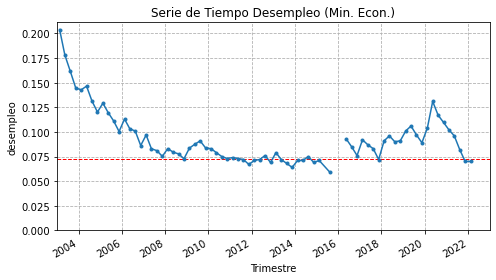

In [27]:
empleo = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/empleoARG/main/datos/45.2_ECTDT.csv')
empleo = empleo[['45.2_IT_0_T_13', '45.2_ECTDT_0_T_33']] # ('45.2_ECTDT_0_T_33' es tasa de desocupacion en total aglomerados)
empleo['Q'] = pd.to_datetime(empleo['45.2_IT_0_T_13']) + pd.DateOffset(months=1, days = 14)
empleo = empleo.set_index('Q').drop(['45.2_IT_0_T_13'], axis = 1)
empleo = empleo.replace('s/d', np.nan).astype(float).round(4)
empleo['censo2010_ratio'] = (empleo/empleo.loc['2010-11-15'])


fig, axs = plt.subplots(1, figsize = (7, 4))

axs.set_title('Serie de Tiempo Desempleo (Min. Econ.)')

axs.axhline(empleo.loc['2010-11-15']['45.2_ECTDT_0_T_33'], color = 'r', lw = 1, linestyle = '--')
empleo['45.2_ECTDT_0_T_33'].plot(marker = '.', ax = axs); #plt.xlim(0, 20)

axs.set_xlim('2003', '2023')
axs.set_ylim(0, )
axs.grid(linestyle = '--')
axs.set_xlabel('Trimestre')
axs.set_ylabel('desempleo')

plt.tight_layout()
plt.savefig('./../images/serie_empleo.jpg')
display(empleo.tail())

0.073

## Tasa de desempleo en censo 2010

In [3]:
## notar que la tasa en Aglos, segun el censo, no es igual al valor de la serie de tiempo.
# para oct 2010 el censo da (6.29 %) y la que tenemos en dato (7.5%)
desoc_C2010 = pd.read_csv('./../data/info/desoc_AGLOsi_C2010.csv')
tasa_C2010 = desoc_C2010.loc[desoc_C2010.AGLO_si == True]['Tasa desocupacion'].values[0]
tasa_C2010

0.0628729377307203

# Predicting

## Lista de trimestres con modelos ya calculados

In [4]:
import datetime as dt
## Trimestres con ingresos disponibles (depende de disponibilidad de microdatos EPH)
import glob

fuente_modelos = 'encuestador-de-hogares' # 'indice-pobreza-ExactasUBA'
# path = '/media/miglesia/Elements/suite/'+fuente_modelos+'/fitted_RF/clf4_' # use your path
path = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf4_'

allFiles = []
# allFiles += glob.glob(path +'*.sav')
# allqs = [f[-18:-8] for f in allFiles]

allFiles += glob.glob(path +'*')
allqs = [f[-14:-4] for f in allFiles]
print(sorted(allqs)[:10])
print(sorted(allqs)[-10:])

['2017-02-15', '2017-05-15', '2017-08-15', '2017-11-15', '2019-02-15', '2019-05-15', '2019-08-15', '2019-11-15', '2020-02-15', '2020-05-15']
['2019-11-15', '2020-02-15', '2020-05-15', '2020-08-15', '2020-11-15', '2021-02-15', '2021-05-15', '2021-08-15', '2021-11-15', '2022-02-15']


In [5]:
import gc
import joblib

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

if not os.path.exists('./../data/yr_samples'):
    os.makedirs('./../data/yr_samples')

## Parametros

### Anios a calcular

In [6]:
### IMPORTANTE ELEGIR ANIOS
startyr = 2021
endyr = 2022

### Elegir el dataset usado como X:
# experiment_tag = 'ARG'
# models_tag = 'ARG'

# ### Test 1
# experiment_tag ='hd_test'
# models_tag = 'ARG'
# frac = '0.5'

### Test 2
experiment_tag ='test3'
models_tag = 'ARG'
frac = '0.2'

### Classification 1
Columnas ['CAT_OCUP', 'CAT_INAC', 'CH07']

### Classification 2
Columna INGRESO

### Classification 3
Columnas ['PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K']

### Regresion

In [7]:
1174037/(18645609 + 1174037)

0.059236022681737104

In [8]:
import json

In [9]:
### Funcion ajustar nivel de empleo

def ajustar_empleo(data, verbose = False):

        ratio = empleo.loc[pd.to_datetime(q)].censo2010_ratio
        n_desempleados_ = ratio*(CONDACT_cnts[1] + CONDACT_cnts[2])*tasa_C2010
        desemp_adic = round(n_desempleados_ - CONDACT_cnts.loc[2]) # Desempleados adicionales
        
        print(str(q)[:10])

        if desemp_adic > 0:
            data.loc[
                data.query('CONDACT == 1').sample(desemp_adic).index,
                'CONDACT'
            ] = 2
        elif desemp_adic < 0:
            data.loc[
                data.query('CONDACT == 2').sample(- desemp_adic).index,
                'CONDACT'
            ] = 1

        if verbose:
            desempleo = data.CONDACT.value_counts().loc[2] / (data.CONDACT.value_counts().loc[1] + data.CONDACT.value_counts().loc[2])
            print('desempleo:' + str(desempleo))
        
        return data

In [10]:
def predict_save(X_data, x_cols, y_cols, model_filename, out_filename, balance_proba, tag, overwrite = False):

        # Si todavia no existe la training data de ese anio, o si la opcion overwrite esta activada:
        if (not os.path.exists(out_filename)) or (overwrite): 

            CLF = joblib.load(model_filename)
            
            if balance_proba: ## Prediccion usando predict proba y factores de balance.
                y_out = pd.DataFrame([])
                proba_values = CLF.predict_proba(X_data[x_cols])

                ## Leer factores de archivo json
                with open('/home/miglesia/repositories/encuestador-de-hogares/data/training/factors/'+tag+'.json', 'r') as file:
                    info = json.load(file)
                factors_mean = pd.DataFrame(json.loads(info[tag])).stack()
                factors_mean.index.names = ['variable', 'valor']
                factors_mean.index = factors_mean.index.set_levels(factors_mean.index.levels[1].astype(float).astype(int), level='valor')

                for j, y_col in enumerate(y_cols):

                    y_probas = pd.DataFrame(proba_values[j], columns = factors_mean.loc[y_col].index.values)
                    y_out[y_col] = (y_probas/factors_mean.loc[y_col]).idxmax(1)#.value_counts().sort_index()
                
            else: ## Prediccion sin balance
                y_out = CLF.predict(X_data[x_cols].values)

            ## Listo
            y_censo_fit = pd.DataFrame(y_out, index = X_data.index, columns=y_cols)
            
            Xy_censo = pd.concat([X_data, y_censo_fit], axis = 1)

#             save
            Xy_censo.to_csv(out_filename, index = False)
            print('File saved at '+ out_filename)
            del X_data; del Xy_censo; del CLF
            gc.collect()

In [11]:
overwrite = True

In [12]:


for yr in [str(s) for s in range(startyr, endyr)]:
    print(yr)
    file_ = '/media/miglesia/Elements/suite/yr_samples/table_f'+str(frac)+'_'+yr+'_'+experiment_tag+'.csv'

    X_censo = pd.read_csv(file_, usecols = ['DPTO','RADIO_REF_ID','PERSONA_REF_ID', 'HOGAR_REF_ID','IX_TOT', 'P02', 'P03', 'CONDACT', 'AGLOMERADO', 'URP', 'V01', 'H05', 'H06',
           'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14', 'AGLO_rk', 'Reg_rk',
           'H13', 'P07', 'P08', 'P09', 'P10', 'P05']).fillna(0)

    ## Tratamiento trimestral 
    qs = np.array(allqs)[[i for i, si in enumerate(allqs) if si.startswith(yr)]]
    print(qs)
    
    CONDACT_cnts = X_censo.CONDACT.value_counts()
    
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])
    
    ### Cargar modelos de la parte no trimestral (anual).
    for q in sorted(qs):
        
        ### AJUSTAR NIVEL DE DESEMPLEO
        X_q = X_censo.copy()
        X_q['Q'] = q
        print('Nuevo trimestre.')

        X_q = ajustar_empleo(X_q)

        #################################    #################################    #################################
        
        print('C1')
        ## CLASIF 1
        X_data = X_q;
        y_cols1 = ['CAT_OCUP', 'CAT_INAC', 'CH07']
        x_cols1 = ['IX_TOT', 'P02', 'P03', 'AGLO_rk', 'Reg_rk', 'V01', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
       'H13', 'P07', 'P08', 'P09', 'P10', 'P05', 'CONDACT']
        out_filename1 = '/media/miglesia/Elements/suite/yr_samples/RFC1_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

        predict_save(X_data,
                     x_cols = x_cols1,
                     y_cols = y_cols1,
                     out_filename = out_filename1,
                     model_filename = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf1_'+yr+'_'+models_tag,
                     balance_proba = True,
                     tag = 'clf1_'+yr+'_'+models_tag,
                    overwrite = overwrite)
        
        del X_q; del X_data
#         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

        #################################    #################################    #################################

        print('C2')
        ## CLASIF 2
        X_data = pd.read_csv(out_filename1)
        y_cols2 = ['INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS']
        x_cols2 = x_cols1 + y_cols1
        out_filename2 = '/media/miglesia/Elements/suite/yr_samples/RFC2_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

        predict_save(X_data,
                     x_cols = x_cols2,
                     y_cols = y_cols2,
                     out_filename = out_filename2,
                     model_filename = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf2_'+yr+'_'+models_tag,
                     balance_proba = True,
                     tag = 'clf2_'+yr+'_'+models_tag,
                    overwrite = overwrite)

        del X_data
#         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

        #################################    #################################    #################################

        print('C3')

        ## CLASIF 3
        X_data = pd.read_csv(out_filename2)
        y_cols3 = ['PP07G1','PP07G_59', 'PP07I', 'PP07J', 'PP07K']
        x_cols3 = x_cols2 + y_cols2
        out_filename3 = '/media/miglesia/Elements/suite/yr_samples/RFC3_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

        predict_save(X_data,
                     x_cols = x_cols3,
                     y_cols = y_cols3,
                     out_filename = out_filename3,
                     model_filename = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf3_'+yr+'_'+models_tag,
                     balance_proba = True,
                     tag = 'clf3_'+yr+'_'+models_tag,
                    overwrite = overwrite)
        del X_data
#         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

        #################################    #################################    #################################

        
        # Columnas de ingresos. Necesitan una regresion...
        columnas_pesos = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']

        x_cols4 = x_cols3 + y_cols3
        # Columnas de ingresos. Necesitan una regresion...
        predecir4 = columnas_pesos
        y_cols4 = predecir4


        print('reg')
        # REGRESION            
        out_filename4 = '/media/miglesia/Elements/suite/yr_samples/RFReg_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'
        if (not os.path.exists(out_filename4)) or (overwrite): 

            ## Cargar Modelo
            model_filename4 = '/home/miglesia/repositories/encuestador-de-hogares/fitted_RF/clf4_'+str(q)[:10]+'_'+models_tag
    #         filename = '/media/miglesia/Elements/CENSO_dirs/Pobreza/fitted_RF/clf4_0.02_'+str(q)[:10]+'_'+experiment_tag+'.sav'
#             clf4 = pickle.load(open(model_filename4+'sav', 'rb'))
            clf4 = joblib.load(model_filename4)

            Xy3_censo = pd.read_csv(out_filename3)
            y_out4 = clf4.predict(Xy3_censo[x_cols4].values); del clf4
            y_censo_fit4 = pd.DataFrame(y_out4, index = Xy3_censo.index, columns=predecir4)

            Xy4_censo = pd.concat([Xy3_censo, y_censo_fit4], axis = 1)
#             save
            Xy4_censo.to_csv(out_filename4, index = False)

            del Xy4_censo;
            gc.collect()
                                
    del X_censo; #del clf1; del clf2; del clf3


2021
['2021-05-15' '2021-11-15' '2021-02-15' '2021-08-15']
[('X_censo', 45155736), ('empleo', 3944), ('HTML', 1064), ('RandomForestClassifier', 1064), ('RandomForestRegressor', 1064)]
Nuevo trimestre.
2021-02-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.2_2021-02-15_test3.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.2_2021-02-15_test3.csv
C3
File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.2_2021-02-15_test3.csv
reg
Nuevo trimestre.
2021-05-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.2_2021-05-15_test3.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.2_2021-05-15_test3.csv
C3
File saved at /media/miglesia/Elements/suite/yr_samples/RFC3_0.2_2021-05-15_test3.csv
reg
Nuevo trimestre.
2021-08-15
C1
File saved at /media/miglesia/Elements/suite/yr_samples/RFC1_0.2_2021-08-15_test3.csv
C2
File saved at /media/miglesia/Elements/suite/yr_samples/RFC2_0.2_2021-08-15_test3.csv
C3
File save

In [13]:
empleo.tail()#.loc[pd.to_datetime(q)].censo2010_ratio

,45.2_ECTDT_0_T_33,censo2010_ratio
Q,,
2021-02-15,0.102,1.397260
2021-05-15,0.096,1.315068
2021-08-15,0.082,1.123288
2021-11-15,0.070,0.958904
2022-02-15,0.070,0.958904
